<a href="https://colab.research.google.com/github/dafeRoy/pytorch_intro/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# convert MNIST image files into a tensor of 4-dimensions
transform = transforms.ToTensor()

In [3]:
# data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.93MB/s]


In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
pwd

'/content'

In [6]:
ls

data/  sample_data/


In [7]:
# create a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# define cnn model
# describe convolutional layer and what it is doing: 2 convolutional layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
# grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1, 1, 28, 28) # 1 batch, 1 image, size 28x28

In [12]:
# perform first convolution
x = F.relu(conv1(x)) #rectified linear unit for our activation function

In [13]:
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
# 1 single image, 6 is the kernels/filters we asked for,
# 26x26 is from our image size 28x28, but since we did not set the padding,
# the padding around the image was dropped (2pix x 2pix)

In [15]:
# pass through the pooling layer
x = F.max_pool2d(x, 2, 2) # kernel size of 2, stride size of 2

In [16]:
x.shape

torch.Size([1, 6, 13, 13])

In [17]:
# we used a pooling kernel size of 2, so 26 / 2 = 13

In [18]:
# do the second convolution layer
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [19]:
# again we did not set padding so we lost 2pix

In [20]:
# pass through another pooling layer
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 16, 5, 5])

In [21]:
# 11 / 2 = 5.5 so round down bcos we can not invent data to round up

In [22]:
# model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120) # from the second pooling values, 120 is arbitrary
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    # second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # re-view to flatten it out
    X = X.view(-1, 5*5*16) # -1 so we can vary the batch size

    # fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [24]:
# create instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # the smaller the lr, the longer the training time

In [33]:
import time
start_time = time.time()

# create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1 # start batches at 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1] # add up number of correct predictions, indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct
    trn_corr += batch_corr # keep track as we go along in traing

    # update our parameters/do some back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b % 600 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item()}')
  train_losses.append(loss.detach().numpy())
  train_correct.append(trn_corr)

  # test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()
  loss = criterion(y_val, y_test)
  test_losses.append(loss.detach().numpy())
  test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f"Trainting took: {total / 60} minutes!")

epoch: 0  batch: 600  loss: 3.0755691113881767e-06
epoch: 0  batch: 1200  loss: 0.00034465439966879785
epoch: 0  batch: 1800  loss: 2.1717651179642417e-05
epoch: 0  batch: 2400  loss: 3.5047037272306625e-06
epoch: 0  batch: 3000  loss: 0.0
epoch: 0  batch: 3600  loss: 2.622601300572569e-07
epoch: 0  batch: 4200  loss: 0.0013605189742520452
epoch: 0  batch: 4800  loss: 0.0
epoch: 0  batch: 5400  loss: 0.002211557701230049
epoch: 0  batch: 6000  loss: 1.2420884559105616e-05
epoch: 1  batch: 600  loss: 0.0
epoch: 1  batch: 1200  loss: 5.364406661101384e-07
epoch: 1  batch: 1800  loss: 2.7894584491150454e-06
epoch: 1  batch: 2400  loss: 5.936462002864573e-06
epoch: 1  batch: 3000  loss: 1.0609572882458451e-06
epoch: 1  batch: 3600  loss: 1.192092824453539e-08
epoch: 1  batch: 4200  loss: 6.847421173006296e-05
epoch: 1  batch: 4800  loss: 6.925929483259097e-06
epoch: 1  batch: 5400  loss: 1.6808395457701408e-06
epoch: 1  batch: 6000  loss: 0.0
epoch: 2  batch: 600  loss: 7.390949576802086e-

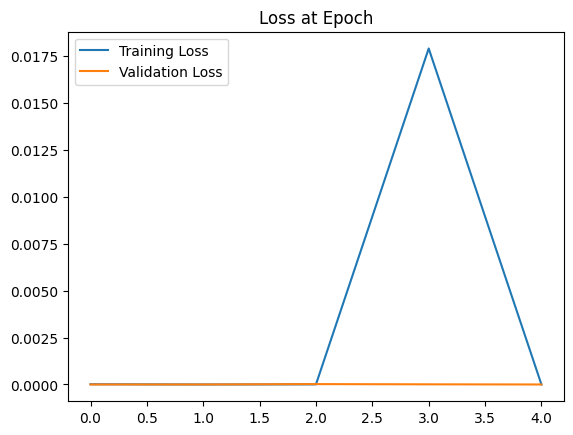

In [34]:
# graph loss at epoch
#train_losses = [tl.item() for tl in train_losses]
#test_losses = [tl.item() for tl in test_losses]
#train_losses = [t.cpu().detach().numpy() for t in train_losses]
#test_losses = [t.cpu().detach().numpy() for t in test_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title("Loss at Epoch")
plt.legend()

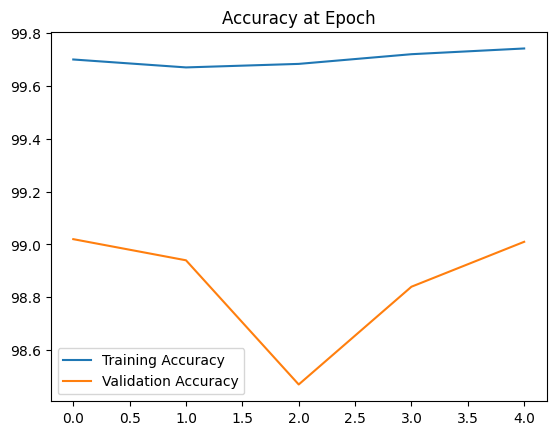

In [35]:
# plot accuracy att epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title("Accuracy at Epoch")
plt.legend()

In [36]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [37]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test Accuracy: {correct.item() / len(test_data)}')

Test Accuracy: 0.9901


In [38]:
# grab an image
test_data[4143] # tensor with an image in it

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [39]:
# grab image without label
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [40]:
# reshape it
test_data[4143][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

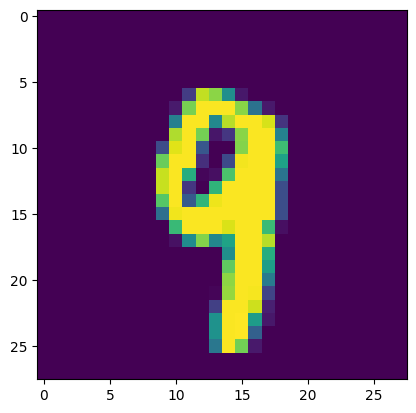

In [41]:
# show the image
plt.imshow(test_data[4143][0].reshape(28, 28))

In [42]:
# pass image through model
model.eval()
with torch.no_grad():
  new_pred = model(test_data[4143][0].view(1, 1, 28, 28))

In [43]:
# check the new prediction
new_pred

tensor([[-4.1850e+01, -3.3172e+01, -3.7805e+01, -3.7047e+01, -1.3436e+01,
         -3.9822e+01, -5.6878e+01, -2.4491e+01, -2.3588e+01, -1.4305e-06]])

In [44]:
new_pred.argmax()

tensor(9)